# Import dependencies

In [16]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=False)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 99.4 ms, sys: 120 ms, total: 219 ms
Wall time: 218 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 10000

# Investigate raw data

In [4]:
%%time

show=False
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    event = raw.loc[raw.index==evID]
    plot_event(event).plot_eventdisplay()
    
    data_eval = evaluate_data(raw)
    data_eval.plot_pzcut(2)
    data_eval.curler_dist()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


# Graph building for training

In [5]:
%%time

data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
create_g = False

if create_g:
    graphs = data.create_graph_list()
    targets = []
    dir = 'data/graphs'

    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))

    for graph in graphs:
        evID = graph.pid.index.unique()[0]
        x, edge_attr, edge_index, y, pid = graph
        targets.append(y)
        arr = np.asanyarray([x, edge_attr, edge_index, y, pid], dtype=object)
        np.save(f'{dir}/graph_{evID}.npy', arr)
    print(f'graphs saved to {dir}')

    targets = np.concatenate(targets)
    print(f'signal fraction true/all edges: {np.sum(targets)/len(targets)}')
    
else:
    graphs = load_graphs('data/graphs', nevents)

#show preprocessed data
data.events.sort_index()

CPU times: user 3.44 s, sys: 300 ms, total: 3.74 s
Wall time: 3.65 s


,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,788814,27.522499,309.390015,0.381878,3.068213,1,0,1,7,155,3,310.611766,0.088724
0,1226939,31.562500,326.894989,0.027868,7.657753,2,0,2,9,108,5,328.415172,0.096254
0,1319193,46.207500,467.839691,0.140725,7.638686,4,0,2,32,131,16,470.116060,0.098449
0,384495,16.412500,466.964996,0.054954,5.260012,4,0,4,31,52,15,467.253334,0.035133
0,648825,-10.352500,310.264679,0.026543,7.725218,1,0,3,8,76,4,310.437345,-0.033354
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,1990571,5.807500,295.769684,0.067946,6.893122,1,0,3,2,17,2,295.826694,0.019633
10000,1825711,10.857500,394.869690,0.013371,7.419455,3,0,0,18,159,10,395.018933,0.027489
10000,910814,36.612499,393.994995,0.050805,6.633860,3,0,1,17,111,9,395.692471,0.092660


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [6]:
%%time
evaluate_gb = False

if evaluate_gb:
    slope = np.linspace(0.1,4,20)
    testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

    purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False)
        purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = np.mean(purity)
        efficiencies[i] = np.mean(efficiency)


    plot_information().plot_purity_efficiency(slope, 3, purities, efficiencies, 'slope cut', 'graph building', 'img/graphbuilding_purity_efficiency.pdf')

    plot_information(graphs=graphs).plot_graph_information()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.2 µs


# Plot Graphs

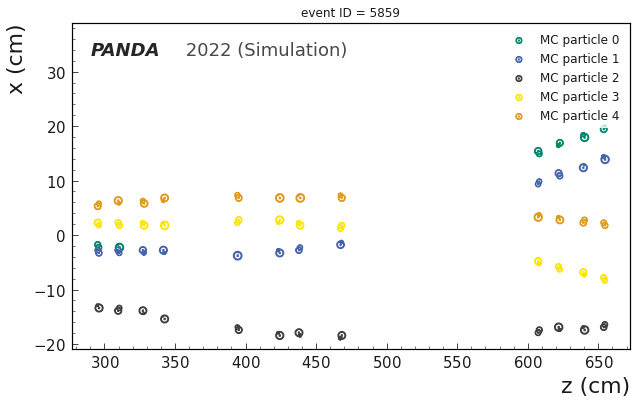

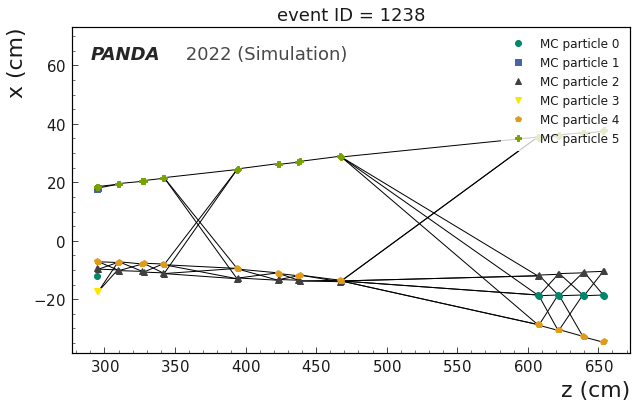

CPU times: user 1.44 s, sys: 267 ms, total: 1.7 s
Wall time: 1.41 s


In [7]:
%%time
evID = np.random.randint(nevents)

hits = data.events.loc[evID]
graph = graphs[evID]

plot_event(hits).plot_eventdisplay()
plot_event(graph=graph).plot_graphdisplay()



# Prepare Training

In [8]:
torch.manual_seed(42)
device = torch.device('cpu')
name = 'test'
hidden_size = 30
lr = 0.01
gamma = 0.7
epochs = 20
patience = 4
step_size = 5
batch_size = 1
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 6}

In [9]:
parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [10]:
model = InteractionNetwork(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 3, edge_dim: 4, hidden_size: 30)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |    300     |
|  R1.layers.0.bias  |     30     |
| R1.layers.2.weight |    900     |
|  R1.layers.2.bias  |     30     |
| R1.layers.4.weight |    120     |
|  R1.layers.4.bias  |     4      |
| O.layers.0.weight  |    210     |
|  O.layers.0.bias   |     30     |
| O.layers.2.weight  |    900     |
|  O.layers.2.bias   |     30     |
| O.layers.4.weight  |     90     |
|  O.layers.4.bias   |     3      |
| R2.layers.0.weight |    300     |
|  R2.layers.0.bias  |     30     |
| R2.layers.2.weight |    900     |
|  R2.layers.2.bias  |     30     |
| R2.layers.4.weight |     30     |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 3938


# Training

In [12]:
results = train_model(train_loader, val_loader, model, optimizer, scheduler, epochs=epochs, patience=patience, name=name)

  0%|                                                                                                                                                                 | 0/20 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 109.68s
Mean Train Batch Loss: 0.1622


  5%|███████▌                                                                                                                                                | 1/20 [01:54<36:22, 114.85s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9361

Validation loss decreased (inf --> 0.148408).  Saving model ...
Train Epoch: 2, epoch time: 108.54s
Mean Train Batch Loss: 0.1423


 10%|███████████████▏                                                                                                                                        | 2/20 [03:48<34:11, 113.99s/it]


Test set: Average loss: 0.0003
, Accuracy: 0.9147

EarlyStopping counter: 1 out of 4
Train Epoch: 3, epoch time: 109.19s
Mean Train Batch Loss: 0.1382


 15%|██████████████████████▊                                                                                                                                 | 3/20 [05:42<32:18, 114.06s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9433

Validation loss decreased (0.148408 --> 0.134179).  Saving model ...
Train Epoch: 4, epoch time: 110.03s
Mean Train Batch Loss: 0.1332


 20%|██████████████████████████████▍                                                                                                                         | 4/20 [07:37<30:29, 114.37s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9433

Validation loss decreased (0.134179 --> 0.132181).  Saving model ...
Train Epoch: 5, epoch time: 109.54s
Mean Train Batch Loss: 0.1278


 25%|██████████████████████████████████████                                                                                                                  | 5/20 [09:31<28:35, 114.38s/it]


Test set: Average loss: 0.0005
, Accuracy: 0.9455

Validation loss decreased (0.132181 --> 0.127746).  Saving model ...
Train Epoch: 6, epoch time: 111.25s
Mean Train Batch Loss: 0.1177


 30%|█████████████████████████████████████████████▌                                                                                                          | 6/20 [11:27<26:49, 114.96s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9499

Validation loss decreased (0.127746 --> 0.114353).  Saving model ...
Train Epoch: 7, epoch time: 110.68s
Mean Train Batch Loss: 0.1125


 35%|█████████████████████████████████████████████████████▏                                                                                                  | 7/20 [13:23<24:57, 115.20s/it]


Test set: Average loss: 0.0003
, Accuracy: 0.9488

EarlyStopping counter: 1 out of 4
Train Epoch: 8, epoch time: 110.26s
Mean Train Batch Loss: 0.1096


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 8/20 [15:18<23:02, 115.19s/it]


Test set: Average loss: 0.0000
, Accuracy: 0.9535

Validation loss decreased (0.114353 --> 0.108708).  Saving model ...
Train Epoch: 9, epoch time: 110.44s
Mean Train Batch Loss: 0.1074


 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 9/20 [17:13<21:07, 115.22s/it]


Test set: Average loss: 0.0002
, Accuracy: 0.9510

EarlyStopping counter: 1 out of 4
Train Epoch: 10, epoch time: 111.39s
Mean Train Batch Loss: 0.1056


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 10/20 [19:10<19:15, 115.57s/it]


Test set: Average loss: 0.0000
, Accuracy: 0.9501

EarlyStopping counter: 2 out of 4
Train Epoch: 11, epoch time: 110.12s
Mean Train Batch Loss: 0.1015


 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 11/20 [21:05<17:18, 115.43s/it]


Test set: Average loss: 0.0000
, Accuracy: 0.9555

Validation loss decreased (0.108708 --> 0.101209).  Saving model ...
Train Epoch: 12, epoch time: 108.06s
Mean Train Batch Loss: 0.1010


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12/20 [22:58<15:17, 114.75s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9556

Validation loss decreased (0.101209 --> 0.100382).  Saving model ...
Train Epoch: 13, epoch time: 111.09s
Mean Train Batch Loss: 0.1009


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13/20 [24:54<13:26, 115.16s/it]


Test set: Average loss: 0.0002
, Accuracy: 0.9550

EarlyStopping counter: 1 out of 4
Train Epoch: 14, epoch time: 109.82s
Mean Train Batch Loss: 0.1007


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14/20 [26:49<11:30, 115.03s/it]


Test set: Average loss: 0.0000
, Accuracy: 0.9509

EarlyStopping counter: 2 out of 4
Train Epoch: 15, epoch time: 110.18s
Mean Train Batch Loss: 0.0997


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15/20 [28:44<09:35, 115.06s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9555

EarlyStopping counter: 3 out of 4
Train Epoch: 16, epoch time: 110.54s
Mean Train Batch Loss: 0.0980


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 16/20 [30:39<07:40, 115.18s/it]


Test set: Average loss: 0.0000
, Accuracy: 0.9558

Validation loss decreased (0.100382 --> 0.099239).  Saving model ...
Train Epoch: 17, epoch time: 111.85s
Mean Train Batch Loss: 0.0973


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 17/20 [32:36<05:47, 115.70s/it]


Test set: Average loss: 0.0003
, Accuracy: 0.9553

EarlyStopping counter: 1 out of 4
Train Epoch: 18, epoch time: 112.22s
Mean Train Batch Loss: 0.0974


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 18/20 [34:33<03:52, 116.12s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9557

EarlyStopping counter: 2 out of 4
Train Epoch: 19, epoch time: 111.55s
Mean Train Batch Loss: 0.0972


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 19/20 [36:30<01:56, 116.21s/it]


Test set: Average loss: 0.0001
, Accuracy: 0.9559

Validation loss decreased (0.099239 --> 0.098956).  Saving model ...
Train Epoch: 20, epoch time: 110.22s
Mean Train Batch Loss: 0.0970


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [38:25<00:00, 115.28s/it]


Test set: Average loss: 0.0000
, Accuracy: 0.9564

Validation loss decreased (0.098956 --> 0.097947).  Saving model ...


In [13]:
model, losses, accs, test_losses, test_accs = results.trained

# Evaluate Training

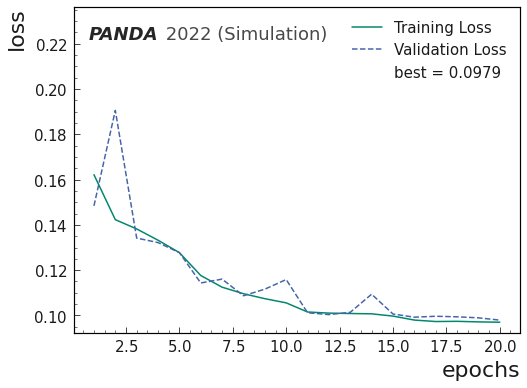

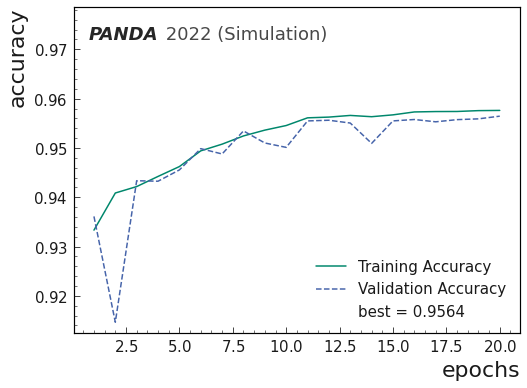

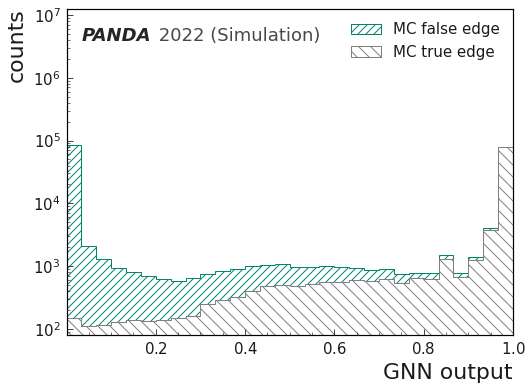

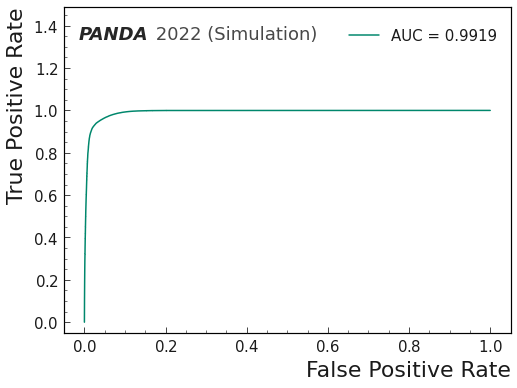

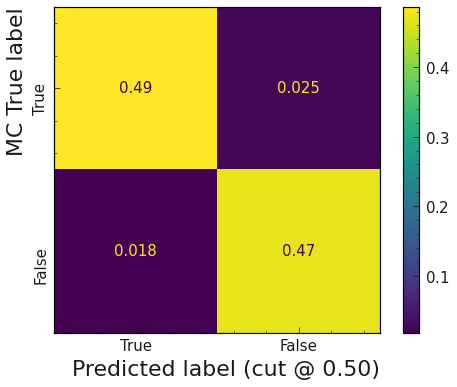

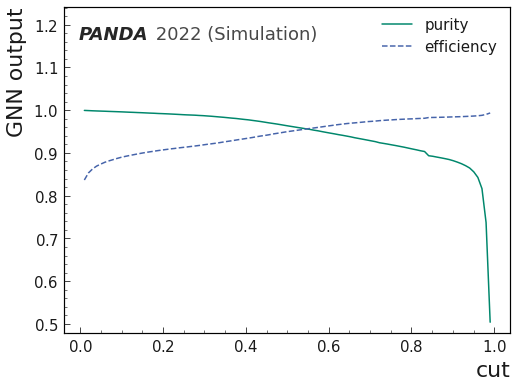

In [14]:
threshold = 0.6
evaluation = evaluate_model('cpu', model, test_loader, losses, test_losses, accs, test_accs, threshold, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

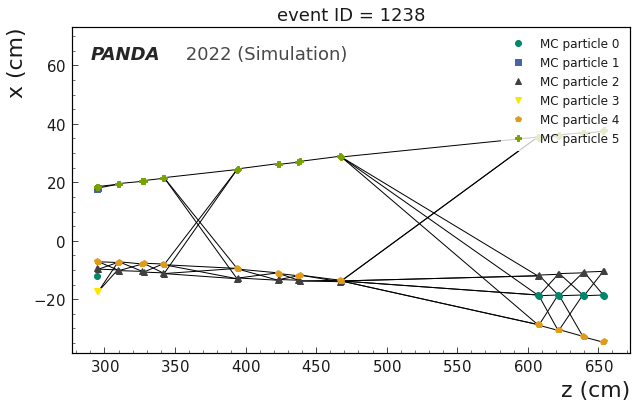

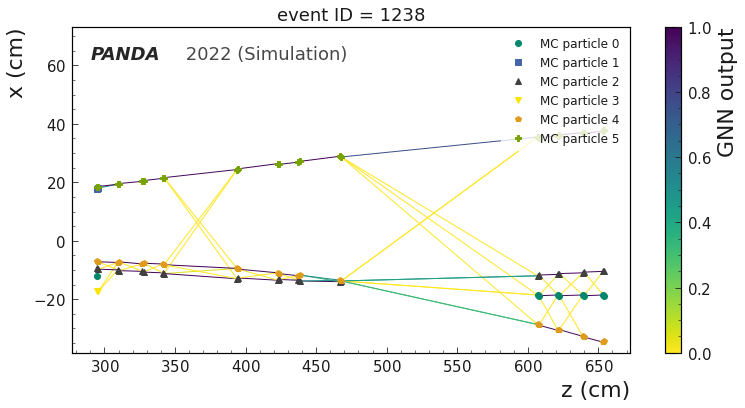

In [15]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)